In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
dataframe = pd.read_csv("./data/data_banknote_authentication.txt", header=None,
                       names=["variance", "skewness", "curtosis", "entropy", "class"])

#### Let's take a look on data

In [3]:
dataframe.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


#### Data description

In [4]:
for column in dataframe.columns:
    print(column + ": min = " + str(dataframe[column].min()) + ", max: " + str(dataframe[column].max()))
    if column == "class":
        print(str(dataframe[column].value_counts().shape[0]) + " classes")

variance: min = -7.0421, max: 6.8248
skewness: min = -13.7731, max: 12.9516
curtosis: min = -5.2861, max: 17.9274
entropy: min = -8.5482, max: 2.4495
class: min = 0, max: 1
2 classes


So as to discretize data we may choose an arbitrary value as a pivot and consider numerical feature as a binary one. However, it's hard to come up with good pivot point. Here we will apply linear search for the problem.

#### Let's plot distributions so as to get some insight about features

(array([  16.,   25.,   35.,   72.,  124.,  120.,  220.,  363.,  343.,   54.]),
 array([-8.5482 , -7.44843, -6.34866, -5.24889, -4.14912, -3.04935,
        -1.94958, -0.84981,  0.24996,  1.34973,  2.4495 ]),
 <a list of 10 Patch objects>)

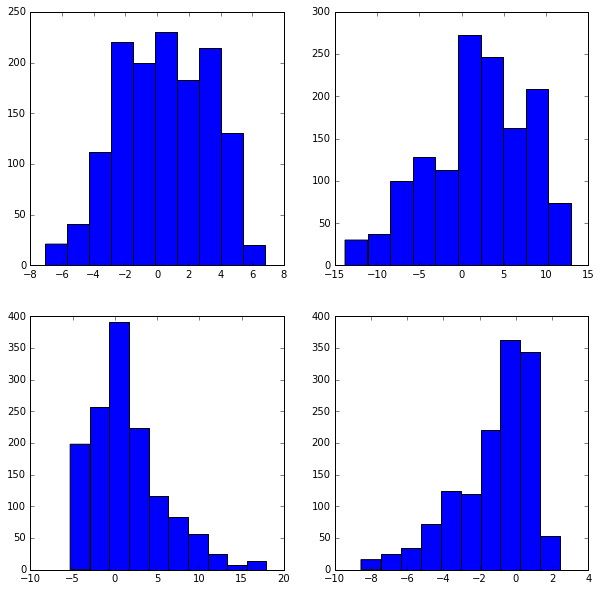

In [5]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.hist(dataframe["variance"])
plt.subplot(2, 2, 2)
plt.hist(dataframe["skewness"])
plt.subplot(2, 2, 3)
plt.hist(dataframe["curtosis"])
plt.subplot(2, 2, 4)
plt.hist(dataframe["entropy"])

#### Sampling functions

In [6]:
def split_with_replacement(dataframe, n):
    m = dataframe.shape[0]
    indices = np.random.randint(0, m, n)
    indices_comp = np.random.randint(0, m, m - n)
    return pd.DataFrame([dataframe.ix[i] for i in indices]), pd.DataFrame([dataframe.ix[i] for i in indices_comp])

def split_without_replacement(dataframe, n):
    m = dataframe.shape[0]
    assert(n <= m)
    indices = []
    for i in range(n):
        index = np.random.randint(0, m)
        if index not in indices:
            indices.append(index)
    return pd.DataFrame([dataframe.ix[i] for i in indices]), \
           pd.DataFrame([dataframe.ix[i] for i in range(m) if i not in indices])

#### Produce datasets

In [7]:
np.random.seed(42)
n = dataframe.shape[0]
dataset = {}
dataset["0.2_with_repl"] = split_with_replacement(dataframe, int(n * 0.2))
dataset["0.2_w/o_repl"] = split_without_replacement(dataframe, int(n * 0.2))
dataset["0.4_with_repl"] = split_with_replacement(dataframe, int(n * 0.4))
dataset["0.4_w/o_repl"] = split_without_replacement(dataframe, int(n * 0.4))

In [8]:
def get_split_value(arr):
    """
    arr: 2d numpy array. First column is for values to be split, second is classes column
    return: (v, score), v - the best value for to binary split the data according to Gini impurity index
                        score - gain in Gini impurity index
    """
    n = arr.shape[0]
    classes = np.unique(arr[:, 1])
    sorted_data = arr[arr[:, 0].argsort()]
    gini_impurities = []
    for i in range(1, n):
        accumulator = 1
        for c in classes:
            accumulator -= \
            i / n * np.square(np.where(sorted_data[:i, 1] == c)[0].shape[0] / i) + \
            (1 - i / n) * np.square(np.where(sorted_data[i:, 1] == c)[0].shape[0] / (n - i))
        gini_impurities.append(accumulator)

    index = np.argmin(gini_impurities)
    return sorted_data[index][0], gini_impurities[index]

#### Finding the best feature for splitting

In [9]:
print("The entire set: ")
overall_impurity = 1 - np.sum(np.square(dataframe["class"].value_counts() / dataframe.shape[0]))
print("Initial Gini impurity: " + str(overall_impurity))

for feature in dataframe.columns:
    if feature == "class":
        continue
    result = get_split_value(dataframe[[feature, "class"]].values)
    print("Feature: ", feature, ". Split point: ", result[0], ". Gini impurity: ", result[1], ".")
    
print()
for split in dataset.keys():
    print(split, ": ")
    df = dataset[split][0]
    overall_impurity = 1 - np.sum(np.square(df["class"].value_counts() / df.shape[0]))
    print("Initial Gini impurity: " + str(overall_impurity))
    for feature in df.columns:
        if feature == "class":
            continue
        result = get_split_value(df[[feature, "class"]].values)
        print("Feature: ", feature, ". Split point: ", result[0], ". Gini impurity: ", result[1], ".")
    print()

The entire set: 
Initial Gini impurity: 0.49386310125882926
Feature:  variance . Split point:  0.31803 . Gini impurity:  0.246799334918 .
Feature:  skewness . Split point:  5.1401 . Gini impurity:  0.377254370618 .
Feature:  curtosis . Split point:  8.6564 . Gini impurity:  0.447093578671 .
Feature:  entropy . Split point:  1.5806 . Gini impurity:  0.491422783493 .

0.2_w/o_repl : 
Initial Gini impurity: 0.4987906476753561
Feature:  variance . Split point:  0.2952 . Gini impurity:  0.214989864269 .
Feature:  skewness . Split point:  4.8856 . Gini impurity:  0.393713568017 .
Feature:  curtosis . Split point:  8.4182 . Gini impurity:  0.452313296903 .
Feature:  entropy . Split point:  -5.8741 . Gini impurity:  0.477711893966 .

0.4_w/o_repl : 
Initial Gini impurity: 0.49777777777777776
Feature:  variance . Split point:  0.2952 . Gini impurity:  0.243240038955 .
Feature:  skewness . Split point:  5.0097 . Gini impurity:  0.390406770136 .
Feature:  curtosis . Split point:  8.6127 . Gini im

So, for the entire set, the best variant to split data is by variance. Splitting value is 0.31803.

#### Classification using decision trees

Results for 0.2_w/o_repl
confusion matrix: 
 [[127   1]
 [  6 110]]
accuracy: 0.97131147541
precision: 0.990990990991
recall: 0.948275862069
sensitivity: 0.9921875

Results for 0.4_w/o_repl
confusion matrix: 
 [[225   7]
 [  6 197]]
accuracy: 0.970114942529
precision: 0.96568627451
recall: 0.970443349754
sensitivity: 0.969827586207

Results for 0.4_with_repl
confusion matrix: 
 [[278   1]
 [  5 264]]
accuracy: 0.989051094891
precision: 0.996226415094
recall: 0.981412639405
sensitivity: 0.996415770609

Results for 0.2_with_repl
confusion matrix: 
 [[139   2]
 [  0 133]]
accuracy: 0.992700729927
precision: 0.985185185185
recall: 1.0
sensitivity: 0.985815602837



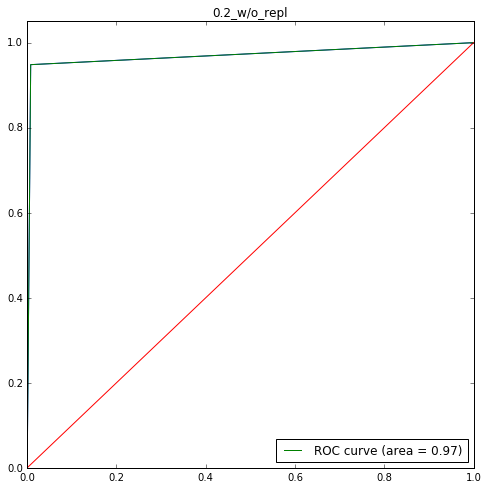

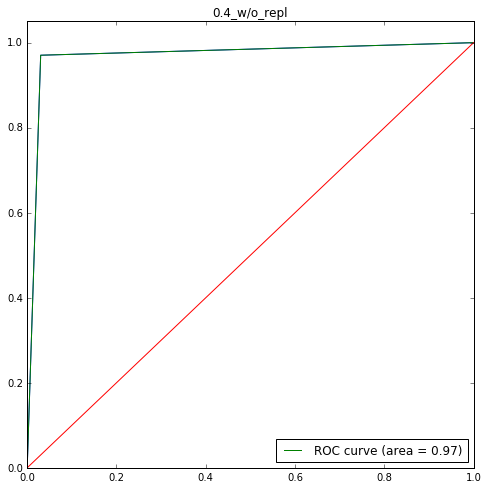

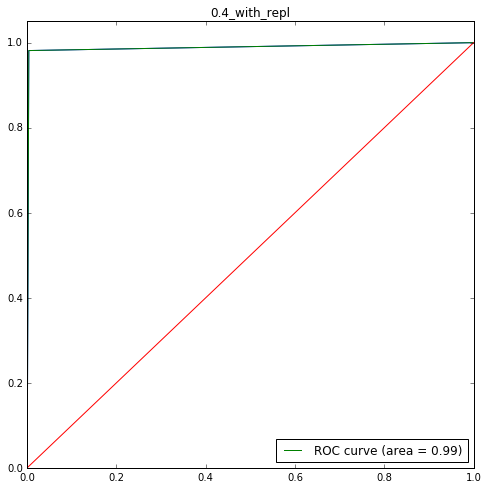

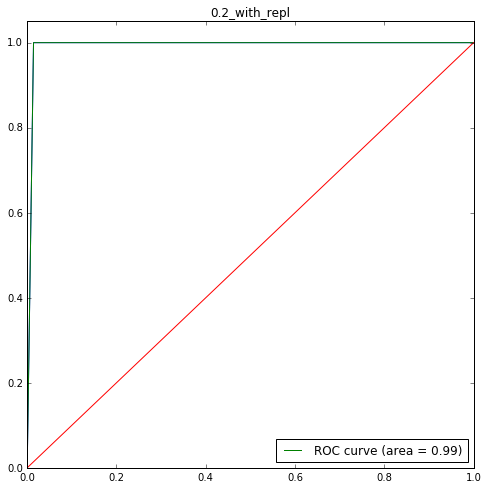

In [10]:
for name, ds in dataset.items():
    print("Results for", name)
    X_train, X_test = ds[1].drop("class", axis=1), ds[0].drop("class", axis=1)
    y_train, y_test = ds[1]["class"], ds[0]["class"]
    classifier = DecisionTreeClassifier(criterion='gini')
    classifier.fit(X_train, y_train)
    acc = classifier.score(X_test, y_test)
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)
    cmatrix = confusion_matrix(y_test, y_pred)
    print("confusion matrix: \n", cmatrix)
    print("accuracy:", acc)
    print("precision:", precision_score(y_test, y_pred))
    print("recall:", recall_score(y_test, y_pred))
    print("sensitivity:", cmatrix[0][0] / (cmatrix[0][0] + cmatrix[0][1]))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], drop_intermediate=False)
    fig = plt.figure(figsize=(8, 8))
    plt.ylim(0, 1.05)
    plt.title(name)
    plt.plot(fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1])
    print()

#### Classification using Naive Bayes classifier

Results for 0.2_w/o_repl
confusion matrix: 
 [[114  14]
 [ 24  92]]
accuracy: 0.844262295082
precision: 0.867924528302
recall: 0.793103448276
sensitivity: 0.890625

Results for 0.4_w/o_repl
confusion matrix: 
 [[198  34]
 [ 38 165]]
accuracy: 0.834482758621
precision: 0.829145728643
recall: 0.812807881773
sensitivity: 0.853448275862

Results for 0.4_with_repl
confusion matrix: 
 [[242  37]
 [ 65 204]]
accuracy: 0.813868613139
precision: 0.846473029046
recall: 0.758364312268
sensitivity: 0.867383512545

Results for 0.2_with_repl
confusion matrix: 
 [[116  25]
 [ 15 118]]
accuracy: 0.85401459854
precision: 0.825174825175
recall: 0.887218045113
sensitivity: 0.822695035461



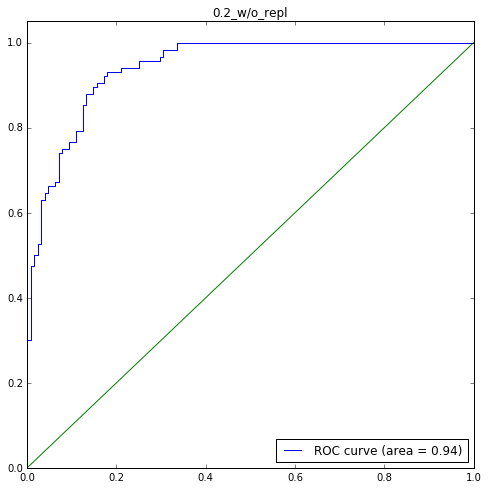

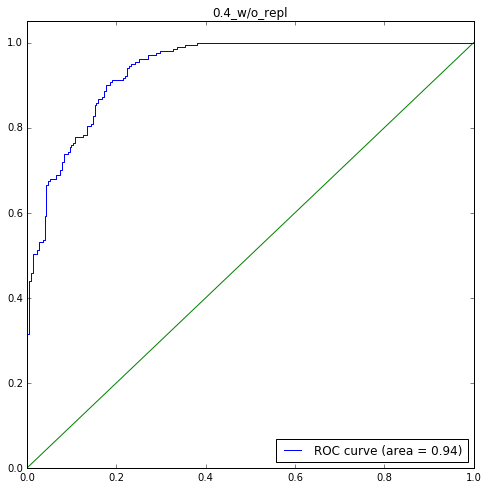

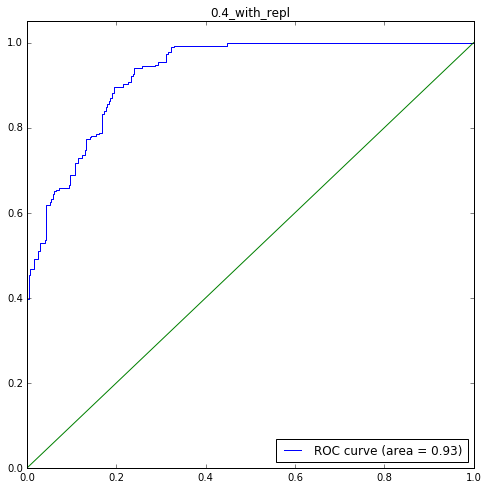

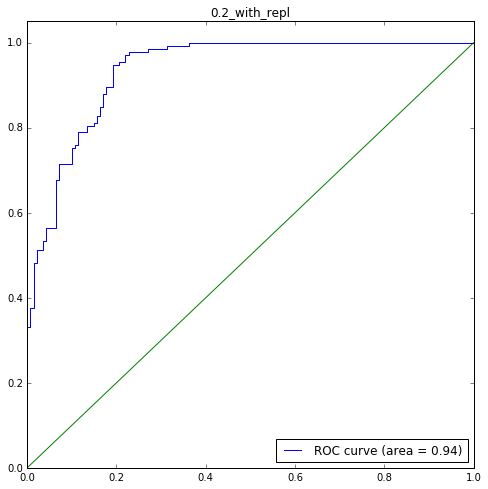

In [11]:
for name, ds in dataset.items():
    print("Results for", name)
    X_train, X_test = ds[1].drop("class", axis=1), ds[0].drop("class", axis=1)
    y_train, y_test = ds[1]["class"], ds[0]["class"]
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    acc = classifier.score(X_test, y_test)
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)
    cmatrix = confusion_matrix(y_test, y_pred)
    print("confusion matrix: \n", cmatrix)
    print("accuracy:", acc)
    print("precision:", precision_score(y_test, y_pred))
    print("recall:", recall_score(y_test, y_pred))
    print("sensitivity:", cmatrix[0][0] / (cmatrix[0][0] + cmatrix[0][1]))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], drop_intermediate=False)
    fig = plt.figure(figsize=(8, 8))
    plt.ylim(0, 1.05)
    plt.title(name)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1])
    print()

Definitely decision tree classifier is better here, at least because of better measured performance. The main reason for that is the core assumption about features independency in naive bayesian classifier. It clearly does not hold here (variance, skewness and kurtosis are statistic moments whcich do have something in common)

Improvement the bayesian classifier may involve some corrections related to functional dependency between features.
Improvement of tree methods clearly involve ensebling. However, we can impose some constraints on the resulting tree according to the current task (max depth, min number of children etc.) so as to slightly improve predictive ability.

#### So, let's get some fun with enseble methods and xtreme gradient boosting!

Also, it's a common practice to use grid search so as to find the best hyperparameters. So we will use Scikit-learn class GridSearchCV, which splits training dataset into data actually used in training and cross-validation data. Cross-validation data aren't presented to classifier during training, so it's an unbiased measurement of predictive ability. However, testing lots of classifiers may result in so-called 'p-hacking'. Therefore we have a real test set which remain silent until we have chosen hyperparameters.

Results for 0.2_w/o_repl
confusion matrix: 
 [[127   1]
 [  0 116]]
accuracy: 0.995901639344
precision: 0.991452991453
recall: 1.0
sensitivity: 0.9921875

Results for 0.4_w/o_repl
confusion matrix: 
 [[230   2]
 [  0 203]]
accuracy: 0.995402298851
precision: 0.990243902439
recall: 1.0
sensitivity: 0.991379310345

Results for 0.4_with_repl
confusion matrix: 
 [[277   2]
 [  0 269]]
accuracy: 0.996350364964
precision: 0.992619926199
recall: 1.0
sensitivity: 0.992831541219

Results for 0.2_with_repl
confusion matrix: 
 [[141   0]
 [  0 133]]
accuracy: 1.0
precision: 1.0
recall: 1.0
sensitivity: 1.0



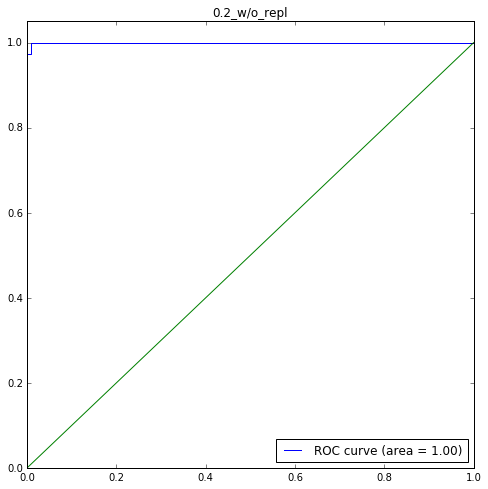

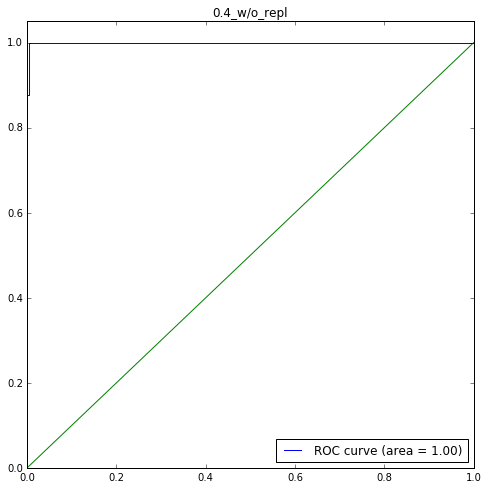

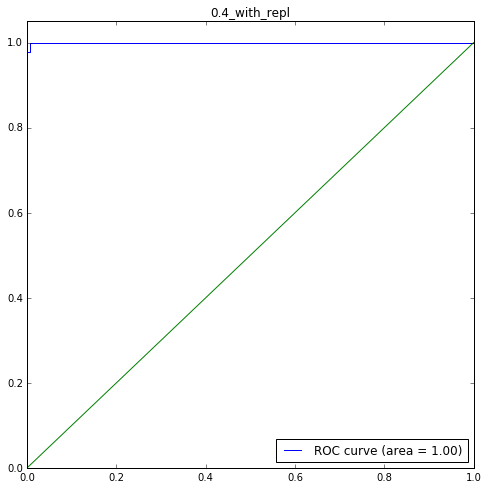

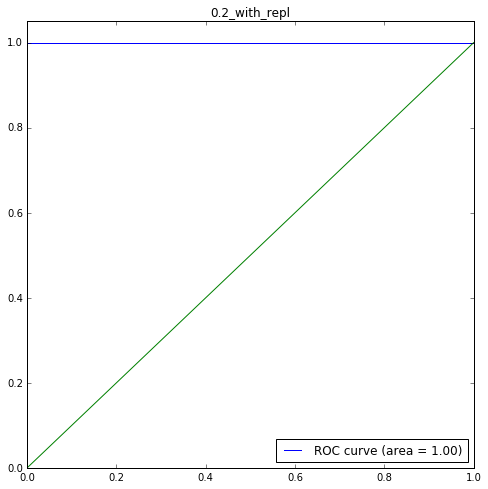

In [12]:
tunable_params = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.03, 0.1, 0.3, 1.0],
    'n_estimators': [10, 20, 30, 40]
}

for name, ds in dataset.items():
    classifier = XGBClassifier()
    grid = GridSearchCV(classifier, tunable_params, cv=5)
    print("Results for", name)
    X_train, X_test = ds[1].drop("class", axis=1), ds[0].drop("class", axis=1)
    y_train, y_test = ds[1]["class"], ds[0]["class"]
    grid.fit(X_train, y_train)
    acc = grid.score(X_test, y_test)
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)
    cmatrix = confusion_matrix(y_test, y_pred)
    print("confusion matrix: \n", cmatrix)
    print("accuracy:", acc)
    print("precision:", precision_score(y_test, y_pred))
    print("recall:", recall_score(y_test, y_pred))
    print("sensitivity:", cmatrix[0][0] / (cmatrix[0][0] + cmatrix[0][1]))
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1], drop_intermediate=False)
    fig = plt.figure(figsize=(8, 8))
    plt.ylim(0, 1.05)
    plt.title(name)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.plot([0, 1])
    print()

Nothing special, 'with replacement' method gave better performance. It's because some examples are in both training and testing set, so we observe the phenomenon called 'overfit'.